#Description

In this approach, the WRDS dataset was used but the names of the companies from the descriptions were removed. Additionally, the descriptions that only contained the name of the company, were also removed (This is the reason for the smaller number of entries in this dataset compared to the WRDS dataset). We first labeled the indices for the different sectors and then partitioned them into training and testing sets (80-20 split). Prior to training the model, we preprocessed the company descriptions to remove any irrelevant information. We used the sentence transformer, specifically the 'all-mpnet-base-v2' model, to embed the preprocessed training and testing sets. These embedded sets were then fed into the OneVsRestClassifier to be trained.
The OneVsRestClassifier employed the Support Vector Classifier (SVC) model as an estimator with the default radial basis function (rbf) kernel and deafult number of iterations.

To further evaluate the performance of ChatGPT and our model in classifying company descriptions, we examined the descriptions that our model had incorrectly predicted. The removed company names from these descriptions played a significant role in eliminating potential bias resulting from ChatGPT's prior knowledge about these companies.

ChatGPT also had difficulty in classifying these descriptions, suggesting that they pose a challenge for natural language processing models in general.


#Importing and preprocessing the dataset cleaned from company names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/drive/MyDrive/clean.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector,Cleansed
0,3,A.A. IMPORTING CO INC,255040,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade,"The company designs, manufactures, and supplie..."
1,4,AAR CORP,201010,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade,The company provides products and services to ...
2,7,ABKCO INDUSTRIES INC,254010,25.0,334612.0,"ABKCO Music & Records, Inc. operates as an ent...",220.0,Consumer Discretionary,33,Manufacturing,The company operates as an entertainment compa...
3,9,ABS INDUSTRIES INC,151040,15.0,3321.0,"Makes cold and warm forgings, including transm...",355.0,Materials,33,Manufacturing,"Makes cold and warm forgings, including transm..."
4,10,ACF INDUSTRIES INC,203040,20.0,336510.0,ACF Industries LLC operates as a machinery (co...,610.0,Industrials,33,Manufacturing,The company LLC operates as a machinery (const...


In [ ]:
data = data[data.columns[2:]]

In [ ]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [ ]:
data.dropna(subset=['Cleansed'], how='any', inplace=True)

In [ ]:
data['gind'] = data['gind'].astype(int)

In [ ]:
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

In [ ]:
import math

temp = []
for item in data["gind"]:
  temp.append(math.floor(item/10000))

data["gind"] = temp

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["gind"] = encoder.fit_transform(data["gind"])
data["gind"].value_counts()

6     5363
7     5192
3     4662
5     4565
2     3934
1     3833
0     2822
4     1433
8     1285
9      740
10     509
Name: gind, dtype: int64

In [ ]:
import re
import string

def preprocess_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)

    return text

In [ ]:
data["Cleansed"] = data["Cleansed"].map(preprocess_text)

In [ ]:
data.head()

,gind,busdesc,Cleansed
0,3,"A.A. Importing Company, Inc. designs, manufact...",the company designs manufactures and supplies ...
1,2,AAR Corp. provides products and services to co...,the company provides products and services to ...
2,3,"ABKCO Music & Records, Inc. operates as an ent...",the company operates as an entertainment compa...
3,1,"Makes cold and warm forgings, including transm...",makes cold and warm forgings including transmi...
4,2,ACF Industries LLC operates as a machinery (co...,the company llc operates as a machinery constr...


In [ ]:
my_tags = list(gics_sector.values())
len(my_tags)

11

#Train and test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data["Cleansed"],  data["gind"], test_size=0.2, random_state=0)

In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=1654087f9462e4eaf30f6dcac23f01d763596bda096eabffd8fcb83693ec487d
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


#Embedding, training the model and making predictions

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

X_train_embed = model.encode(list(X_train))

X_test_embed = model.encode(list(X_test))

clf = OneVsRestClassifier(SVC())

clf.fit(X_train_embed, Y_train)

y_pred = clf.predict(X_test_embed)

#Results from predictions on the Cleaned test set

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_test, y_pred, average='micro')))

[[450  24  21   8   2   4  20  13   0   3   0]
 [ 21 682  29  12  13  11  12  11   2   0   0]
 [ 14  48 458  63   7  25  30 106   6  12   0]
 [  5  16  70 665  39  20  39  78  24   3   1]
 [  3  10   3  22 183  26   9   3   0   1   0]
 [  5   8  16  10  10 783  26  17   1   1   1]
 [  9   9  19  26   4  16 935  22   3   4  11]
 [ 11  12  56  45   3  29  41 882  24   2   1]
 [  1   1   7  39   0  10  11  49 117   1   0]
 [ 12   1   7   1   0   1  11   1   0 116   0]
 [  0   2   2   2   0   4  35   6   2   0  60]]
                                            precision    recall  f1-score   support

                                    Energy       0.85      0.83      0.84       545
                                 Materials       0.84      0.86      0.85       793
                               Industrials       0.67      0.60      0.63       769
Consumer Discretionary (Consumer Cyclical)       0.74      0.69      0.72       960
     Consumer Staples (Consumer Defensive)       0.70      0.

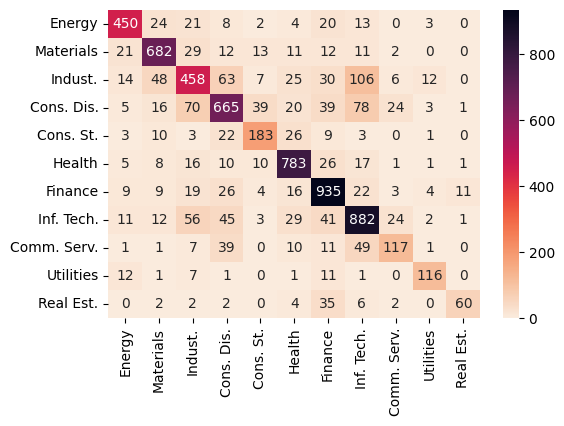

#Extracting the wrongly classified descriptions

In [ ]:
wrong = []
counter = 0

for i in range(len(y_pred)):
  if y_pred[i] != list(Y_test)[i]:
    predicted_key = encoder.classes_[y_pred[i]]
    predicted = gics_sector[predicted_key]
    true_key = encoder.classes_[list(Y_test)[i]]
    true = gics_sector[true_key]
    counter = counter +1

    wrong.append((counter, predicted, true, list(X_test)[i]))

In [ ]:
wrong

[(1,
  'Energy',
  'Consumer Discretionary (Consumer Cyclical)',
  'vibra the company manufactures processes distributes trades transports imports and exports fuels and lubricants in brazil'),
 (2,
  'Consumer Discretionary (Consumer Cyclical)',
  'Utilities',
  'the company formerly known as the company operates as a subsidiary of the company inc'),
 (3,
  'Consumer Discretionary (Consumer Cyclical)',
  'Information Technology',
  'the company purchases and sells principal vehicle inventory to individual customers on a retail basis or to wholesale customers in the united states it also provides financing warranty and aftermarket sales related to the purchase of the retail units'),
 (4,
  'Industrials',
  'Financials',
  'as of the company was acquired by the company'),
 (5,
  'Consumer Discretionary (Consumer Cyclical)',
  'Industrials',
  'on august 16 2000 the voluntary petition of the company for reorganization under chapter 11 was converted to chapter 7 it had filed for chapter 11

In [ ]:
wrong_descriptions = []

for (counter, predicted, true, desc) in wrong:
  wrong_descriptions.append(desc)

#OpenAI API

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.0 MB/s eta 0:00:00


In [ ]:
import openai

openai.api_key = 'your-API-key-here'

In [ ]:
def generate_response(text):
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages = [
          {"role": "user", "content": "Your task is to classify a company based on its textual description using GICS. You will classify the sector of the company. Your response shall ONLY be the name of the sector. If you can't classify the company or there isn't enough information, then the response will only be 'None'. The format of the response should only be the name of the sector. Example: 'Energy'. Here is the description: " + text},
      ]
  )
  return response

In [ ]:
def extract_relations(text):
  response = generate_response(text)
  response_string = response['choices'][0].message.content
  response_string = response_string.replace("\n\n", "")
  return response_string

In [ ]:
import time

gpt_preds = []

#ChatGPT predictions on the wrongly classfied

Note: Because of a Connection timeout error, 1445 descriptions were classified instead of the 1537 descriptions, but this number is sufficient.

In [ ]:
for item in wrong_descriptions:
  gpt_preds.append(extract_relations(item))
  time.sleep(20)

Timeout: ignored

In [ ]:
len(gpt_preds)

1445

In [ ]:
len(wrong_descriptions)

1537

In [ ]:
test_wrong = []

for (counter, predicted, true, desc) in wrong[:1445]:
  if true == "Consumer Staples (Consumer Defensive)":
    test_wrong.append("Consumer Staples")
  elif true == "Consumer Discretionary (Consumer Cyclical)":
    test_wrong.append("Consumer Discretionary")
  else:
    test_wrong.append(true)

#Editing the classifications to the corresponding names of the sectors

In [ ]:
gpt_preds_clean = []

for item in gpt_preds:
  item = item.replace(".", "")
  item = item.replace("sector", "")
  item = item.replace("Sector", "")
  item = item.replace("sectors", "")
  item = item.replace(":", "")
  if "None" in item:
    item = "None"
  if item == "Communications Services":
    item = "Communication Services"
  if item == "Consumer staples":
    item = "Consumer Staples"
  if "Health" in item:
    item = "Health Care"
  if "Industrials" in item:
    item = "Industrials"
  if "belongs" in item:
    item = "Communication Services"
  if item == "Information Technology Services":
    item = "Information Technology"
  if item == "Retailing":
    item = "Consumer Discretionary"
  if item == "Education":
    item = "Consumer Discretionary"
  if item == "Telecommunication Services":
    item = "Communication Services"
  item = item.strip()
  gpt_preds_clean.append(item)

#Results from the wrongly classified predictions

In [ ]:
print(confusion_matrix(test_wrong, gpt_preds_clean))
print(classification_report(test_wrong, gpt_preds_clean))
print("F1 score is: "+ (str)(f1_score(test_wrong, gpt_preds_clean, average='micro')))

[[ 43   4   0   0   2   8  10  32   1  14   1   0]
 [ 26  26  13   2   4  14  62  42  11  68   5   2]
 [  0  15   5   1   2  20   1   1  11  17   1   0]
 [  0   0   0   9   4   1  16   4  22  36   1   1]
 [  2   3   0   1   4   7  11   8   6  44  28   2]
 [  1   0   2   3   1  14  11   5   4  44   3   1]
 [  4  14   1  11   8  13 102  49  33  51   0   8]
 [ 21   8   1   8   9  10  42  39   3  60   1   2]
 [  2   4   6   6   5   8  20   2  26  25   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   3   0   6  37   0]
 [  0   1   0   7   0   0   3   0   1  12   1   6]]
                        precision    recall  f1-score   support

Communication Services       0.43      0.37      0.40       115
Consumer Discretionary       0.34      0.09      0.15       275
      Consumer Staples       0.18      0.07      0.10        74
                Energy       0.19      0.10      0.13        94
            Financials       0.10      0.03      0.05       116
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


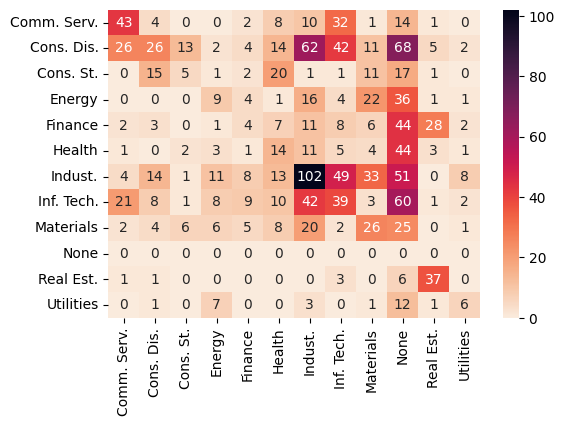

#Comparison between the predictions of our model and the predictions from ChatGPT only on the wrongly classified descriptions

In [ ]:
final = []
counter = 0

for i in range(len(y_pred[:1445])):
  if y_pred[i] != list(Y_test)[i]:
    predicted_key = encoder.classes_[y_pred[i]]
    predicted = gics_sector[predicted_key]
    true_key = encoder.classes_[list(Y_test)[i]]
    true = gics_sector[true_key]
    gpt_predicted = gpt_preds_clean[i]
    counter = counter + 1

    final.append((counter, predicted, gpt_predicted, true, list(X_test)[i]))

In [ ]:
final

[(1,
  'Energy',
  'Energy',
  'Consumer Discretionary (Consumer Cyclical)',
  'vibra the company manufactures processes distributes trades transports imports and exports fuels and lubricants in brazil'),
 (2,
  'Consumer Discretionary (Consumer Cyclical)',
  'None',
  'Utilities',
  'the company formerly known as the company operates as a subsidiary of the company inc'),
 (3,
  'Consumer Discretionary (Consumer Cyclical)',
  'Health Care',
  'Information Technology',
  'the company purchases and sells principal vehicle inventory to individual customers on a retail basis or to wholesale customers in the united states it also provides financing warranty and aftermarket sales related to the purchase of the retail units'),
 (4,
  'Industrials',
  'Consumer Discretionary',
  'Financials',
  'as of the company was acquired by the company'),
 (5,
  'Consumer Discretionary (Consumer Cyclical)',
  'Industrials',
  'Industrials',
  'on august 16 2000 the voluntary petition of the company for re